# Lab 2: Inference in Graphical Models

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people or individually.
* The hand-in deadline is Wednesday, May 10, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2017] lab02\_Bongers\_Blom", the attached file should be "lab02\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask or e-mail Philip.
* For some of the questions, you can write the code directly in the first code cell that provides the class structure.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!

### Introduction
In this assignment, we will implement the sum-product and max-sum algorithms for factor graphs over discrete variables. The relevant theory is covered in chapter 8 of Bishop's PRML book, in particular section 8.4. Read this chapter carefuly before continuing!

We will first implement sum-product and max-sum and apply it to a simple poly-tree structured factor graph for medical diagnosis. Then, we will implement a loopy version of the algorithms and use it for image denoising.

For this assignment we recommended you stick to numpy ndarrays (constructed with np.array, np.zeros, np.ones, etc.) as opposed to numpy matrices, because arrays can store n-dimensional arrays whereas matrices only work for 2d arrays. We need n-dimensional arrays in order to store conditional distributions with more than 1 conditioning variable. If you want to perform matrix multiplication on arrays, use the np.dot function; all infix operators including *, +, -, work element-wise on arrays.

## Part 1: The sum-product algorithm

We will implement a datastructure to store a factor graph and to facilitate computations on this graph. Recall that a factor graph consists of two types of nodes, factors and variables. Below you will find some classes for these node types to get you started. Carefully inspect this code and make sure you understand what it does; you will have to build on it later.

In [43]:
%pylab inline
class Node(object):
    """
    Base-class for Nodes in a factor graph. Only instantiate sub-classes of Node.
    """
    def __init__(self, name,loopyStatus):
        # A name for this Node, for printing purposes
        self.name = name
        
        # Neighbours in the graph, identified with their index in this list.
        # i.e. self.neighbours contains neighbour 0 through len(self.neighbours) - 1.
        self.neighbours = []
        
        # Reset the node-state (not the graph topology)
        self.reset()
        
        self.loopyStatus = loopyStatus
        
    def reset(self):
        # Incoming messages; a dictionary mapping neighbours to messages.
        # That is, it maps  Node -> np.ndarray.
        self.in_msgs = {}
        
        # A set of neighbours for which this node has pending messages.
        # We use a python set object so we don't have to worry about duplicates.
        self.pending = set([])

    def add_neighbour(self, nb):
        self.neighbours.append(nb)

    def send_sp_msg(self, other):
        # To be implemented in subclass.
        raise Exception('Method send_sp_msg not implemented in base-class Node')
   
    def send_ms_msg(self, other):
        # To be implemented in subclass.
        raise Exception('Method send_ms_msg not implemented in base-class Node')
    
    def receive_msg(self, other, msg):
        
        #******************************************************************
        #   RECEIVING MESSAGES (SECTION 1.5)                                                              
        #******************************************************************
        
        
        # Store the incomming message, replacing previous messages from the same node
        self.in_msgs[other] = msg
        
        if self.loopyStatus == False:
            # Non-Loopy BP. Only nodes with complete messages may transmit further.
            # Consider All Messages and All nodes except 'other', 
            
            # All nodes that are neighbours excluding the 'other' node
            nodes_except_other = set([i for i in self.neighbours if i != other])
            sentMsgNodes = set(self.in_msgs.keys()) 
            
            # Message Check on all neighbours that are not 'other' which has completed message passing and is 
            # now excluded.   
            pendingNodes = []
            for node in nodes_except_other:
                # Nodes other than the iterator 'node'
                out_nodes = set([i for i in self.neighbours if i != node])
                
                # Implies that you have not removed a non-critical node from set of nodes that have already sent messages.
                # Such non-critical nodes that do not affect set-membership will be penidng nodes.
                if out_nodes.issubset(sentMsgNodes):
                    pendingNodes.append(node)        
        else:
            # Loopy BP. Incomplete messages 'can' be sent here.
            pendingNodes = list(set(self.neighbours)-set([other]))
        
        self.pending.update(pendingNodes)
        
    
    def __str__(self):
        # This is printed when using 'print node_instance'
        return self.name
    
    def node_check(self,other):
        #Check neighbour info
        #Implement before anything else
        assert other in self.neighbours,"%r is not a valid neighbour of %r" %(other.name,self.name)
        other_neighbours = [oth for oth in self.neighbours if oth != other]
        assert set(other_neighbours).issubset(self.in_msgs.keys()),"Some node(s) may not have sent messages. Unable to proceed."
        #all_received = reduce(lambda acc, n: acc and n in self.in_msgs.keys(), other_neighbours, True)
        #assert all_received, 'Node {} has not all needed information'.format(self.name)

class Variable(Node):
    def __init__(self, name, num_states,loopyStatus=False):
        """
        Variable node constructor.
        Args:
            name: a name string for this node. Used for printing. 
            num_states: the number of states this variable can take.
            Allowable states run from 0 through (num_states - 1).
            For example, for a binary variable num_states=2,
            and the allowable states are 0, 1.
        """
        self.num_states = num_states
        
        # Call the base-class constructor
        super(Variable, self).__init__(name,loopyStatus)
    
    def set_observed(self, observed_state):
        """
        Set this variable to an observed state.
        Args:
            observed_state: an integer value in [0, self.num_states - 1].
        """
        # Observed state is represented as a 1-of-N variable
        # Could be 0.0 for sum-product, but log(0.0) = -inf so a tiny value is preferable for max-sum
        self.observed_state[:] = 0.000001
        self.observed_state[observed_state] = 1.0
        self.set_observed_state = 1.0
    def set_latent(self):
        """
        Erase an observed state for this variable and consider it latent again.
        """
        # No state is preferred, so set all entries of observed_state to 1.0
        # Using this representation we need not differentiate between observed and latent
        # variables when sending messages.
        self.observed_state[:] = 1.0
        self.set_observed_state = 0.0
        
    def reset(self):
        super(Variable, self).reset()
        self.observed_state = np.ones(self.num_states)
        self.set_observed_state = 0.0
        
    def marginal(self, Z=None):
        
        #******************************************************************
        #   COMPUTE MARGINAL (SECTION 1.4)                                                              
        #******************************************************************
        
        #******************************************************************
        #   OBSERVED VARIABLES AND PROBABILISTIC QUERIES (SECTION 1.7)                                                              
        #******************************************************************
        
        """
        Compute the marginal distribution of this Variable.
        It is assumed that message passing has completed when this function is called.
        Args:
            Z: an optional normalization constant can be passed in. If None is passed, Z is computed.
        Returns: marginal, Z. The first is a numpy array containing the normalized marginal distribution.
         Z is either equal to the input Z, or computed in this function (if Z=None was passed).
        """
        
        if self.set_observed_state == 1.0:
            messageProduct = self.observed_state
            
        else:
            messages = [self.in_msgs[var] for var in self.neighbours]
            messageProduct = np.multiply.reduce(messages)

            # Compute Normalization Factor Z by summing up all terms of computed message.

        if Z == None:
            Z = sum(messageProduct)
            
        marginal = messageProduct/float(Z)      
    
        return marginal, Z
    
    def send_sp_msg(self, other):
        
        
        #******************************************************************
        #   VARIABLE TO FACTOR MESSAGES (SECTION 1.3)                                                              
        #******************************************************************
        
        #******************************************************************
        #   OBSERVED VARIABLES AND PROBABILISTIC QUERIES (SECTION 1.7)                                                              
        #******************************************************************
        
        self.node_check(other)
        #assert other in self.neighbours,"%r is not a valid neighbour of %r" %(other,self.name)
    
        if len(self.neighbours) == 1 or self.set_observed_state == 1.0:
            msg = self.observed_state
        
        else:
            other_neighbours = [oth for oth in self.neighbours if oth != other]
            other_index = self.neighbours.index(other)
            
            #assert set(other_neighbours).issubset(self.in_msgs.keys()),"Some node(s) may not have sent messages. Unable to proceed."
            messages = [self.in_msgs[var] for var in other_neighbours]
            msg = np.multiply.reduce(messages)
        
        other.receive_msg(self,msg)
        # Remove 'other form pending list'
        self.pending.discard(other)
   
    def send_ms_msg(self, other):
        
        #******************************************************************
        #   VARIABLE TO FACTOR MESSAGES (SECTION 2.2)                                                              
        #******************************************************************
        
        # Simple Sum of terms.
                
        self.node_check(other)
        
        if len(self.neighbours) == 1 or self.set_observed_state == 1.0:
            msg = np.log(self.observed_state)
        
        else:
            
            other_neighbours = [oth for oth in self.neighbours if oth != other]
#             messages = [self.in_msgs[var] for var in other_neighbours]
#             dimx = [2] * len(other_neighbours)
#             msgVector = np.zeros([dimx])
            
            msg = np.zeros(self.num_states)
            for idx,node in enumerate(other_neighbours):
                msg += self.in_msgs[node] 
            
            # Pass the standard initialization message.
#             if self.set_observed_state == 1.0:
#                 msg = np.log(self.observed_state)
                
#             else:
#                 msg = np.zeros(self.num_states)
            
        # Send Message.
        # print ('Var -> Factor %r') %(msg)
        other.receive_msg(self,msg)
        # Remove 'other form pending list'
        self.pending.discard(other)
        
        #******************************************************************
        #   MAP STATE (SECTION 2.3)                                                              
        #******************************************************************
    
    def MAP(self):
        return np.argmax(np.sum(self.in_msgs.values(),axis=0))

class Factor(Node):
    def __init__(self, name, f, neighbours,loopyStatus=False):
        """
        Factor node constructor.
        Args:
            name: a name string for this node. Used for printing
            f: a numpy.ndarray with N axes, where N is the number of neighbours.
               That is, the axes of f correspond to variables, and the index along that axes corresponds to a value of that variable.
               Each axis of the array should have as many entries as the corresponding neighbour variable has states.
            neighbours: a list of neighbouring Variables. Bi-directional connections are created.
        """
        # Call the base-class constructor
        super(Factor, self).__init__(name,loopyStatus)

        assert len(neighbours) == f.ndim, 'Factor function f should accept as many arguments as this Factor node has neighbours'
        
        for nb_ind in range(len(neighbours)):
            nb = neighbours[nb_ind]
            assert f.shape[nb_ind] == nb.num_states, 'The range of the factor function f is invalid for input %i %s' % (nb_ind, nb.name)
            self.add_neighbour(nb)
            nb.add_neighbour(self)

        self.f = f
        
    def send_sp_msg(self, other):
        
        #******************************************************************
        #   FACTOR TO VARIABLE MESSAGES (SECTION 1.2)                                                              
        #******************************************************************
        self.node_check(other)
          #assert other in self.neighbours,"%r is not a valid neighbour of %r" %(other,self.name)
        
        # Check if input variable 'other' is a vaid neighbour for this factor.
        if len(self.neighbours) == 1:
            msg = self.f;
            
        else:
            
            other_neighbours = [oth for oth in self.neighbours if oth != other]
            
            # Check all neighbours have sent messages. This is vital according to Bishop to check all factors 
            # have received messages before intitiating marginalization.
            
            messages = [self.in_msgs[var] for var in other_neighbours]
            prod = np.multiply.reduce(np.ix_(*messages))
            other_index = self.neighbours.index(other)

            # Compute Marginalization Dimensions. These are all dimensions for excluding the 'other' dimension. 
            # We will hence filter on this specific dimension

            marginalized_dims = filter(lambda x: not x == other_index,range(len(self.neighbours)));
            msg = np.tensordot(self.f,prod,axes=(marginalized_dims,range(prod.ndim)));

        
               
        other.receive_msg(self,msg)
        # Remove 'other form pending list'
        self.pending.discard(other)
   
    def send_ms_msg(self, other):
        
        #******************************************************************
        #   FACTOR TO VARIABLE MESSAGES (SECTION 2.1)                                                              
        #******************************************************************
        
        self.node_check(other)
        if len(self.neighbours) == 1:
            
            # Pass the standard initialization message.
            
            msg = np.log(self.f)
        
        else:
        
            other_neighbours = [oth for oth in self.neighbours if oth != other]
            messages = [self.in_msgs[var] for var in other_neighbours]
            dimx = len(other_neighbours)
            output = 0
            # msgVector = np.zeros([dimx])
            other_index = self.neighbours.index(other) 
            
            for idx,node in enumerate(other_neighbours):
                outVector = [2]*(dimx-idx-1)+[1]*(idx + 1)
                output += np.tile(self.in_msgs[node],outVector)
            
            # Compute Maximization axes. These are all axes except 'other'. Same as in send_sp_msg()
            
            maximization_dims = filter(lambda x: not x == other_index,range(len(self.neighbours)));
            
            # Compute Maxima along an axis. In this case , the final term is a sum so no tensordot needed.
            msg = np.amax(np.log(self.f) + output,axis=tuple(maximization_dims));
        
        
            
        # Send Message.
        # print ('Factor -> Var %r') %(msg)
        other.receive_msg(self,msg)
        # Remove 'other form pending list'
        self.pending.discard(other)
        
        pass


Populating the interactive namespace from numpy and matplotlib


### 1.1 Instantiate network (10 points)
Convert the directed graphical model ("Bayesian Network") shown below to a factor graph. Instantiate this graph by creating Variable and Factor instances and linking them according to the graph structure. 
To instantiate the factor graph, first create the Variable nodes and then create Factor nodes, passing a list of neighbour Variables to each Factor.
Use the following prior and conditional probabilities.

$$
p(\verb+Influenza+) = 0.05 \\\\
p(\verb+Smokes+) = 0.2 \\\\
$$

$$
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 1) = 0.3 \\\\
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 0) = 0.001 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 1) = 0.9 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 0) = 0.05 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 1) = 0.99 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 0) = 0.9 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 1) = 0.7 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 0) = 0.0001 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 1) = 0.8 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 0) = 0.07 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 1) = 0.6 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 0) = 0.001 \\\\
$$

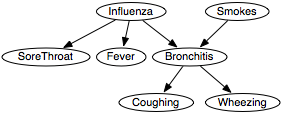

In [44]:
from IPython.core.display import Image 
Image(filename='bn.png') 

In [45]:
# Creating Variables First: ARGS : name,num_states =2 

influenza = Variable('Influenza',2)
smokes = Variable('Smokes',2)
soreThroat = Variable('SoreThroat',2)
fever = Variable('Fever',2)
bronchitis = Variable('Bronchitis',2)
coughing = Variable('Coughing',2)
wheezing = Variable('wheezing',2)


# Creating Factors. All Directed Relationships between variables will constitute factors and 
# will require to be initialized

smokes_prior = Factor('Only given Smokes',np.array([1.-0.2,0.2]),[smokes])
influenza_prior = Factor('Only given Influenza',np.array([1.-0.05,0.05]),[influenza])
soreThroat_influenza = Factor('Sore Throat given Influenza',np.array([[1.-0.001,1.-0.3],[0.001,0.3]]),
                              [soreThroat,influenza])
fever_influenza = Factor('Fever given Influenza',np.array([[1.-0.05,1.-0.9],[0.05,0.9]]),[fever,influenza])
bronchitis_influenza_smokes = Factor('Bronchitis given Influenza and Smokes',np.array([[[1-0.001,1-0.7],
                                     [1-0.9,1-0.99]],[[0.001,0.7],[0.9,0.99]]]),[bronchitis,influenza,smokes])
coughing_bronchitis = Factor('Coughing given Bronchitis',np.array([[1.-0.07,1-0.8],[0.07,0.8]]),
                             [coughing,bronchitis])
wheezing_bronchitis = Factor('Wheezing given Bronchitis',np.array([[1.-0.001,1.-0.6],[0.001,0.6]]),
                             [wheezing,bronchitis])

node_complete = [influenza,smokes,soreThroat,fever,bronchitis,coughing,wheezing,smokes_prior,
                 influenza_prior,soreThroat_influenza,coughing_bronchitis,wheezing_bronchitis,
                 bronchitis_influenza_smokes,fever_influenza]

variable_nodes = [influenza,smokes,soreThroat,fever,bronchitis,coughing,wheezing]



### 1.2 Factor to variable messages (20 points)
Write a method `send_sp_msg(self, other)` for the Factor class, that checks if all the information required to pass a message to Variable `other` is present, computes the message and sends it to `other`. "Sending" here simply means calling the `receive_msg` function of the receiving node (we will implement this later). The message itself should be represented as a numpy array (np.array) whose length is equal to the number of states of the variable.

An elegant and efficient solution can be obtained using the n-way outer product of vectors. This product takes n vectors $\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(n)}$ and computes a $n$-dimensional tensor (ndarray) whose element $i_0,i_1,...,i_n$ is given by $\prod_j \mathbf{x}^{(j)}_{i_j}$. In python, this is realized as `np.multiply.reduce(np.ix_(*vectors))` for a python list `vectors` of 1D numpy arrays. Try to figure out how this statement works -- it contains some useful functional programming techniques. Another function that you may find useful in computing the message is `np.tensordot`.

In [46]:
#Implemented in class(Factor) under method "send_sp_msg"

### 1.3 Variable to factor messages (10 points)

Write a method `send_sp_message(self, other)` for the Variable class, that checks if all the information required to pass a message to Variable var is present, computes the message and sends it to factor.

In [47]:
#Implemented in class(Variable) under method "send_sp_msg"

### 1.4 Compute marginal (10 points)
Later in this assignment, we will implement message passing schemes to do inference. Once the message passing has completed, we will want to compute local marginals for each variable.
Write the method `marginal` for the Variable class, that computes a marginal distribution over that node.

In [48]:
#Implemented in class(Variable) under method "marginal"

### 1.5 Receiving messages (10 points)
In order to implement the loopy and non-loopy message passing algorithms, we need some way to determine which nodes are ready to send messages to which neighbours. To do this in a way that works for both loopy and non-loopy algorithms, we make use of the concept of "pending messages", which is explained in Bishop (8.4.7): 
"we will say that a (variable or factor)
node a has a message pending on its link to a node b if node a has received any
message on any of its other links since the last time it send (sic) a message to b. Thus,
when a node receives a message on one of its links, this creates pending messages
on all of its other links."

Keep in mind that for the non-loopy algorithm, nodes may not have received any messages on some or all of their links. Therefore, before we say node a has a pending message for node b, we must check that node a has received all messages needed to compute the message that is to be sent to b.

Modify the function `receive_msg`, so that it updates the self.pending variable as described above. The member self.pending is a set that is to be filled with Nodes to which self has pending messages. Modify the `send_msg` functions to remove pending messages as they are sent.

In [49]:
#Implemented in class(Node) under method "receive_msg"

### 1.6 Inference Engine (10 points)
Write a function `sum_product(node_list)` that runs the sum-product message passing algorithm on a tree-structured factor graph with given nodes. The input parameter `node_list` is a list of all Node instances in the graph, which is assumed to be ordered correctly. That is, the list starts with a leaf node, which can always send a message. Subsequent nodes in `node_list` should be capable of sending a message when the pending messages of preceding nodes in the list have been sent. The sum-product algorithm then proceeds by passing over the list from beginning to end, sending all pending messages at the nodes it encounters. Then, in reverse order, the algorithm traverses the list again and again sends all pending messages at each node as it is encountered. For this to work, you must initialize pending messages for all the leaf nodes, e.g. `influenza_prior.pending.add(influenza)`, where `influenza_prior` is a Factor node corresponding the the prior, `influenza` is a Variable node and the only connection of `influenza_prior` goes to `influenza`.




In [50]:
def sum_product(graph_nodes):
    # Performs a single pass in one direction
    def f_pass(nodes):
        for node in nodes:
            pending_n = list(node.pending)
            for pend in pending_n:
                node.send_sp_msg(pend)
    
    # Forward pass
    f_pass(graph_nodes)
    # Backward pass
    f_pass(list(reversed(graph_nodes)))

In [51]:
def set_graph(observed=[]):
    # Reset all nodes
    for node in node_complete:
        node.reset()
    
    # Setup leaf nodes
    influenza_prior.pending.add(influenza)
    smokes_prior.pending.add(smokes)
    soreThroat.pending.add(soreThroat_influenza)
    fever.pending.add(fever_influenza)
    coughing.pending.add(coughing_bronchitis)
    wheezing.pending.add(wheezing_bronchitis)

    # Setup graph ordering
    return [influenza_prior, smokes_prior, coughing,
            wheezing, soreThroat, fever, soreThroat_influenza,
            fever_influenza, coughing_bronchitis, wheezing_bronchitis,
            smokes, influenza, bronchitis, bronchitis_influenza_smokes]

    #return [influenza_prior, smokes_prior, coughing,
            #wheezing, soreThroat, fever, coughing_bronchitis,wheezing_bronchitis,bronchitis,
            #soreThroat_influenza,fever_influenza,
            #smokes, influenza, bronchitis_influenza_smokes]

graph_order = set_graph()
# Start sum-product algorithm
sum_product(graph_order)

st_marginal = soreThroat.marginal()
print 'p(sore_throat=0) =', st_marginal[0][0]
print 'p(sore_throat=1) =', st_marginal[0][1]

p(sore_throat=0) = 0.98405
p(sore_throat=1) = 0.01595


### 1.7 Observed variables and probabilistic queries (15 points)
We will now use the inference engine to answer probabilistic queries. That is, we will set certain variables to observed values, and obtain the marginals over latent variables. We have already provided functions `set_observed` and `set_latent` that manage a member of Variable called `observed_state`. Modify the `Variable.send_msg` and `Variable.marginal` routines that you wrote before, to use `observed_state` so as to get the required marginals when some nodes are observed.

<h5> IMPLEMENTED IN CLASS Variable </h5> 

In [52]:
graph_order = set_graph()
influenza.set_observed(1)
smokes.set_observed(1)
bronchitis.set_observed(1)

sum_product(graph_order)

coughing_marginal = coughing.marginal()
print 'p(coughing=0|influenza=1,smokes=1,bronchitis=1) =', coughing_marginal[0][0]
print 'p(coughing=1|influenza=1,smokes=1,bronchitis=1) =', coughing_marginal[0][1]
print ""
st_marginal = soreThroat.marginal()
print 'p(sore_throat=0|influenza=1,smokes=1,bronchitis=1) =', st_marginal[0][0]
print 'p(sore_throat=1|influenza=1,smokes=1,bronchitis=1) =', st_marginal[0][1]
print ""
f_marginal = fever.marginal()
print 'p(fever=0|influenza=1,smokes=1,bronchitis=1) =', f_marginal[0][0]
print 'p(fever=1|influenza=1,smokes=1,bronchitis=1) =', f_marginal[0][1]
print ""

p(coughing=0|influenza=1,smokes=1,bronchitis=1) = 0.200000729999
p(coughing=1|influenza=1,smokes=1,bronchitis=1) = 0.799999270001

p(sore_throat=0|influenza=1,smokes=1,bronchitis=1) = 0.700000299
p(sore_throat=1|influenza=1,smokes=1,bronchitis=1) = 0.299999701

p(fever=0|influenza=1,smokes=1,bronchitis=1) = 0.100000849999
p(fever=1|influenza=1,smokes=1,bronchitis=1) = 0.899999150001



In [53]:
graph_order = set_graph()
influenza.set_observed(1)
smokes.set_observed(0)
bronchitis.set_observed(1)

sum_product(graph_order)

w_marginal = wheezing.marginal()
print 'p(wheezing=0|influenza=1,smokes=0,bronchitis=1) =', w_marginal[0][0]
print 'p(wheezing=1|influenza=1,smokes=0,bronchitis=1) =', w_marginal[0][1]
print ""
f_marginal = fever.marginal()
print 'p(fever=0|influenza=1,smokes=0,bronchitis=1) =', f_marginal[0][0]
print 'p(fever=1|influenza=1,smokes=0,bronchitis=1) =', f_marginal[0][1]
print ""

p(wheezing=0|influenza=1,smokes=0,bronchitis=1) = 0.400000598999
p(wheezing=1|influenza=1,smokes=0,bronchitis=1) = 0.599999401001

p(fever=0|influenza=1,smokes=0,bronchitis=1) = 0.100000849999
p(fever=1|influenza=1,smokes=0,bronchitis=1) = 0.899999150001



### 1.8 Sum-product and MAP states (5 points)
A maximum a posteriori state (MAP-state) is an assignment of all latent variables that maximizes the probability of latent variables given observed variables:
$$
\mathbf{x}_{\verb+MAP+} = \arg\max _{\mathbf{x}} p(\mathbf{x} | \mathbf{y})
$$
Could we use the sum-product algorithm to obtain a MAP state? If yes, how? If no, why not?


No we can't use Sum-Product algorithm to obtain the MAP State. Let $\mathbf{X} = y+x$ where y and x are the observed and latent variables respectively, with the observed variables having value $\bar{y}$. We now introduce Evidence Factors using an Indicator function $\mathcal{I}(y,\bar{y})$ over the observed variables where $\mathcal{I}(y,\bar{y})$  = 1 when $y=\bar{y}$ and 0 otherwise. Then by multiplying the joint distribution $p(\mathbf{X})$ with $\prod_i I(y_i,\bar{y}_i)$ we obtain an unnormalized version of $p(x|y=\bar{y})$ i.e. the posterior marginals.

For each posterior marginal we can find the value of the latent variable which maximizes the marginal. However this yields values which are individually most probable whereas our goal is to obtain an assignment of all latent variables which jointly maximizes the whole posterior probability distribution viz. $p(\mathbf{x|y})$. <b> Therefore we can't use sum product to obtain MAP State </b>

## Part 2: The max-sum algorithm
Next, we implement the max-sum algorithm as described in section 8.4.5 of Bishop.

### 2.1 Factor to variable messages (10 points)
Implement the function `Factor.send_ms_msg` that sends Factor -> Variable messages for the max-sum algorithm. It is analogous to the `Factor.send_sp_msg` function you implemented before.

In [54]:
#implemented in class Factor, under the method send_ms_msg

### 2.2 Variable to factor messages (10 points)
Implement the `Variable.send_ms_msg` function that sends Variable -> Factor messages for the max-sum algorithm.

In [55]:
# implemented in class Variable, under the method send_ms_msg

### 2.3 Find a MAP state (10 points)

Using the same message passing schedule we used for sum-product, implement the max-sum algorithm. For simplicity, we will ignore issues relating to non-unique maxima. So there is no need to implement backtracking; the MAP state is obtained by a per-node maximization (eq. 8.98 in Bishop). Make sure your algorithm works with both latent and observed variables.

In [56]:
import pandas as pd

def maxsum(graph_nodes):
    def pass_thru_all(nodes):
        for node in nodes:
            pending_n = list(node.pending)
            for pend in pending_n:
                node.send_ms_msg(pend)
                
    pass_thru_all(graph_nodes)
    
    pass_thru_all(list(reversed(graph_nodes)))

    i = 0
    mid_arr = [[],[]]
    for node in graph_nodes:
        if node in variable_nodes:
            mid_arr[0].append(node.name)
            mid_arr[1].append(node.MAP())
            #print (node.name,node.MAP())
            i += 1
            
    return np.column_stack((mid_arr[0],mid_arr[1]))

In [57]:
graph_order = set_graph()
# Start sum-product algorithm
df = pd.DataFrame(maxsum(graph_order),columns=['Variable Name','X_MAP'])
print df

  Variable Name X_MAP
0      Coughing     0
1      wheezing     0
2    SoreThroat     0
3         Fever     0
4        Smokes     0
5     Influenza     0
6    Bronchitis     0


In [58]:
graph_order = set_graph()
fever.set_observed(1)
coughing.set_observed(1)

df = pd.DataFrame(maxsum(graph_order),columns=['Variable Name','X_MAP'])
print df

  Variable Name X_MAP
0      Coughing     1
1      wheezing     1
2    SoreThroat     0
3         Fever     0
4        Smokes     1
5     Influenza     1
6    Bronchitis     1


In [59]:
graph_order = set_graph()
influenza.set_observed(1)
smokes.set_observed(0)

df = pd.DataFrame(maxsum(graph_order),columns=['Variable Name','X_MAP'])
print df

  Variable Name X_MAP
0      Coughing     0
1      wheezing     0
2    SoreThroat     0
3         Fever     1
4        Smokes     1
5     Influenza     0
6    Bronchitis     0


## Part 3: Image Denoising and Loopy BP

Next, we will use a loopy version of max-sum to perform denoising on a binary image. The model itself is discussed in Bishop 8.3.3, but we will use loopy max-sum instead of Iterative Conditional Modes as Bishop does.

The following code creates some toy data: `im` is a quite large binary image and `test_im` is a smaller synthetic binary image. Noisy versions are also provided.

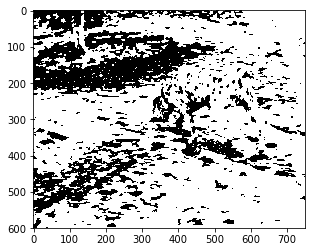

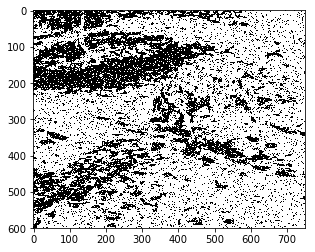

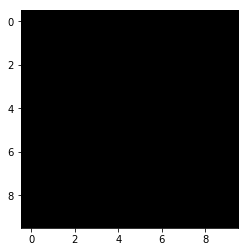

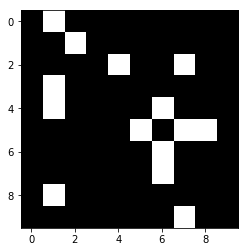

In [60]:
from pylab import imread, gray
# Load the image and binarize
im = np.mean(imread('dalmatian1.png'), axis=2) > 0.5
imshow(im)
gray()

# Add some noise
noise = np.random.rand(*im.shape) > 0.9
noise_im = np.logical_xor(noise, im)
figure()
imshow(noise_im)

test_im = np.zeros((10,10))
#test_im[5:8, 3:8] = 1.0
#test_im[5,5] = 1.0
figure()
imshow(test_im)

# Add some noise
noise = np.random.rand(*test_im.shape) > 0.9
noise_test_im = np.logical_xor(noise, test_im)
figure()
imshow(noise_test_im)

### 3.1 Construct factor graph (10 points)
Convert the Markov Random Field (Bishop, fig. 8.31) to a factor graph and instantiate it.

### 3.2 Loopy max-sum (10 points)
Implement the loopy max-sum algorithm, by passing messages from randomly chosen nodes iteratively until no more pending messages are created or a maximum number of iterations is reached. 

Think of a good way to initialize the messages in the graph.